In [12]:
import mysql.connector
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Connect to MySQL and Load Data
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="24112001",
    database="weather_db"
)
query = "SELECT * FROM weather_forecast WHERE state = 'Oregon'"
df = pd.read_sql(query, conn)
conn.close()
df['forecast_hour_str'] = df['forecast_hour'].astype(str).str.extract(r'(\d{1,2}:\d{2}:\d{2})')[0]

# Step 2: Feature Engineering
df['forecast_datetime'] = pd.to_datetime(df['forecast_date'].astype(str) + ' ' + df['forecast_hour_str'],format="%Y-%m-%d %H:%M:%S")
df['hour'] = df['forecast_datetime'].dt.hour
df['day_of_week'] = df['forecast_datetime'].dt.dayofweek
df['is_morning'] = df['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)

# Step 3: Target Mapping for Classification
df["weather_type"] = df["condition_text"].map({
    "Sunny": "sunny",
    "Clear": "sunny",
    "Partly cloudy": "cloudy",
    "Cloudy": "cloudy",
    "Overcast": "overcast"
})
df = df[df["weather_type"].notna()]

le = LabelEncoder()
df["weather_code"] = le.fit_transform(df["weather_type"])

# Step 4: Prepare Features and Labels
features = ["humidity", "dewpoint_c", "cloud", "wind_kph", "gust_kph", "uv_index", "hour", "day_of_week", "is_morning"]
X = df[features]
y = df["weather_code"]

# Step 5: Train/Val/Test Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Output shape confirmation
print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Train set: (1058, 9)
Validation set: (152, 9)
Test set: (303, 9)


/var/folders/z5/_kg6nkbd33vg1dd32lmybfdh0000gr/T/ipykernel_28953/3360694559.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [7]:
!pip3 install SQLAlchemy

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Step 6: Train the classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 7: Evaluate on validation set
val_preds = clf.predict(X_val)
print("\n📊 Validation Performance:")
print(classification_report(y_val, val_preds, target_names=le.classes_))


📊 Validation Performance:
              precision    recall  f1-score   support

      cloudy       0.98      0.98      0.98        52
    overcast       1.00      1.00      1.00        35
       sunny       0.98      0.98      0.98        65

    accuracy                           0.99       152
   macro avg       0.99      0.99      0.99       152
weighted avg       0.99      0.99      0.99       152



/var/folders/z5/_kg6nkbd33vg1dd32lmybfdh0000gr/T/ipykernel_28953/3890866117.py:9: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


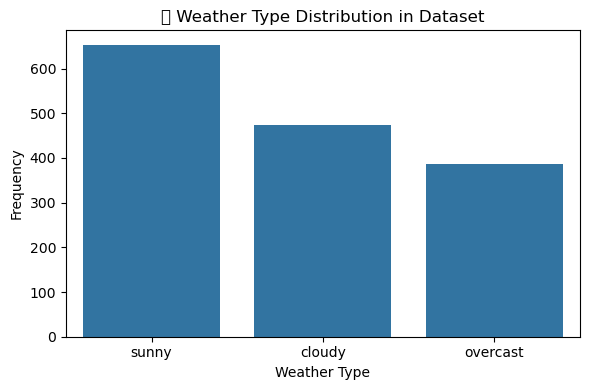

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x=df['weather_type'], order=df['weather_type'].value_counts().index)
plt.title("🌦️ Weather Type Distribution in Dataset")
plt.xlabel("Weather Type")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


/var/folders/z5/_kg6nkbd33vg1dd32lmybfdh0000gr/T/ipykernel_28953/3874198323.py:4: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


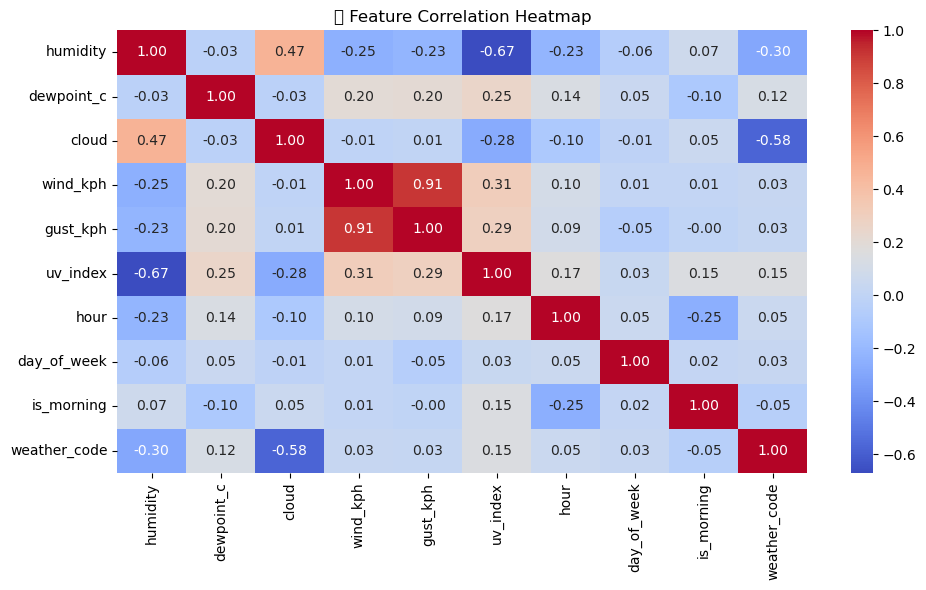

In [18]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[features + ['weather_code']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("📊 Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [22]:
y_test_pred = clf.predict(X_test)
from sklearn.metrics import classification_report

print("\n📊 Test Set Performance:")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))



📊 Test Set Performance:
              precision    recall  f1-score   support

      cloudy       0.95      0.99      0.97        87
    overcast       0.99      0.95      0.97        85
       sunny       1.00      0.99      1.00       131

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303



In [24]:
import mysql.connector
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
import numpy as np

# Step 1: Connect to MySQL and Load Data
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="24112001",
    database="weather_db"
)
query = "SELECT * FROM weather_forecast WHERE state = 'Oregon'"
df = pd.read_sql(query, conn)
conn.close()

# Step 2: Feature Engineering
df['forecast_hour_str'] = df['forecast_hour'].astype(str).str.extract(r'(\d{1,2}:\d{2}:\d{2})')[0]
df['forecast_datetime'] = pd.to_datetime(df['forecast_date'].astype(str) + ' ' + df['forecast_hour_str'], format="%Y-%m-%d %H:%M:%S")
df['hour'] = df['forecast_datetime'].dt.hour
df['day_of_week'] = df['forecast_datetime'].dt.dayofweek
df['is_morning'] = df['hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)

# Step 3: Classification Setup
df["weather_type"] = df["condition_text"].map({
    "Sunny": "sunny",
    "Clear": "sunny",
    "Partly cloudy": "cloudy",
    "Cloudy": "cloudy",
    "Overcast": "overcast"
})
df = df[df["weather_type"].notna()]
le = LabelEncoder()
df["weather_code"] = le.fit_transform(df["weather_type"])

features = ["humidity", "dewpoint_c", "cloud", "wind_kph", "gust_kph", "uv_index", "hour", "day_of_week", "is_morning"]

# Step 4: Train/Test Split for Classification
X = df[features]
y_clf = df["weather_code"]
X_temp, X_test, y_temp, y_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)
X_train_clf, X_val, y_train_clf, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42)

# Step 5: Train Classification Model
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train_clf, y_train_clf)

# Step 6: Evaluate on Validation Set
val_preds = clf_model.predict(X_val)
print("🌤️ Validation Performance:")
print(classification_report(y_val, val_preds, target_names=le.classes_))

# Step 7: Test Set Performance
test_preds = clf_model.predict(X_test)
print("\n📊 Test Set Performance:")
print(classification_report(y_test, test_preds, target_names=le.classes_))

# ============ REGRESSION MODEL (Rain Probability) ============ #
df_rain = df[df["chance_of_rain"].notna()]  # Ensure target is present
X_reg = df_rain[features]
y_reg = df_rain["chance_of_rain"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X_train_reg, y_train_reg)

reg_preds = reg_model.predict(X_test_reg)
rmse = mean_squared_error(y_test_reg, reg_preds, squared=False)
print("\n🌧️ RMSE for Chance of Rain Prediction:", round(rmse, 2))


/var/folders/z5/_kg6nkbd33vg1dd32lmybfdh0000gr/T/ipykernel_28953/3132351672.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


🌤️ Validation Performance:
              precision    recall  f1-score   support

      cloudy       0.98      0.98      0.98        52
    overcast       1.00      1.00      1.00        35
       sunny       0.98      0.98      0.98        65

    accuracy                           0.99       152
   macro avg       0.99      0.99      0.99       152
weighted avg       0.99      0.99      0.99       152


📊 Test Set Performance:
              precision    recall  f1-score   support

      cloudy       0.95      0.99      0.97        87
    overcast       0.99      0.95      0.97        85
       sunny       1.00      0.99      1.00       131

    accuracy                           0.98       303
   macro avg       0.98      0.98      0.98       303
weighted avg       0.98      0.98      0.98       303


🌧️ RMSE for Chance of Rain Prediction: 0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
